## Lab 2-3

In [4]:
!ipc/ipc-static

ipc-static [-Bqsv] [-b buffersize] [-i pipe|local|tcp] [-p tcp_port]
	[-P l1d|l1i|l2|mem|tlb|axi] [-t totalsize] mode

Modes (pick one - default 1thread):
    1thread                IPC within a single thread
    2thread                IPC between two threads in one process
    2proc                  IPC between two threads in two different processes

Optional flags:
    -B                     Run in bare mode: no preparatory activities
    -i pipe|local|tcp      Select pipe, local sockets, or TCP (default: pipe)
    -p tcp_port            Set TCP port number (default: 10141)
    -P l1d|l1i|l2|mem|tlb|axi  Enable hardware performance counters
    -q                     Just run the benchmark, don't print stuff out
    -s                     Set send/receive socket-buffer sizes to buffersize
    -v                     Provide a verbose benchmark description
    -b buffersize          Specify a buffer size (default: 131072)
    -t totalsize           Specify total I/O size (default: 1677

In [5]:
!ipc/ipc-static -i pipe 2thread
!ipc/ipc-static -i local 2thread

274948.53 KBytes/sec
135210.06 KBytes/sec


In [6]:
!ipc/ipc-static -i local -s -b 1024 2thread

46141.98 KBytes/sec


In [7]:
!ipc/ipc-static -v -i pipe 2thread

Benchmark configuration:
  buffersize: 131072
  totalsize: 16777216
  blockcount: 128
  mode: 2thread
  ipctype: pipe
  time: 0.059394292
275851.42 KBytes/sec


In [8]:
!ipc/ipc-static -q -B -i pipe 2thread

In [14]:

setup_kernel()

kern.ipc.maxsockbuf: 33554432 -> 33554432


## Things to do
- [ ] instrument clock_gettime for the IPC loop
- [ ] it may be sensible to inspect quantize() results for both the execution time distributions of the system calls, and the amount of data returned by each
- [ ] investigate scheduling events using the sched provider ( on-cpu and off-cpu events)
- [ ] instrument sleep and wakeup
- [ ] take care about pid and tid
- [ ] probe effect: one simple way to approach the problem is to analyse the results of performance benchmarking with and without DTrace scripts running
- [ ] discard the first result
- [ ] read the FreeBSD Benchmarking Advice wiki
### questions to answer
- How does increasing IPC buffer size uniformly change performance across IPC models – and why?
- Explore the impact of the probe effect on your causal investigation; how has DTrace changed the behavior of the benchmark?


# Benchmark and plot functions

In [55]:
%matplotlib inline

from collections import defaultdict
import json
import re


def setup_kernel():
    !sysctl kern.ipc.maxsockbuf=33554432
# Callback invoked to print the trace record
# (that is, printf("%u", vtimestamp - self->start))

def benchmark(flags, trials, buff_sizes, dtrace_script,output_name="", quiet=False):
    values = []
    aggr_dict = defaultdict(int)

    def simple_out(value):
        values.append(value)
    
    def walk_func(a, b, c, d):
        pass
        #aggr_dict[c[0]] += d
    
    # print_header(["Starting io-static performance measurement",flags])

        # Create a seperate thread to run the DTrace instrumentation
    setup_kernel()
    dtrace_thread = DTraceConsumerThread(dtrace_script,
                                    chew_func=lambda v: None,
                                        chewrec_func=lambda v: None,
                                        out_func=simple_out,
                                        walk_func=walk_func,
                                        sleep=1)

    # Start the DTrace instrumentation
    dtrace_thread.start()

    program_outputs = []
    
    # Display header to indicate that the benchmarking has started
    for size in buff_sizes:
        !sleep 1 

        if not quiet:
            print("buffer size:", size, "collected so far: ",len(values))
        for i in range(trials):
            output = !ipc/ipc-static -B -b {str(size)} {flags} 2thread
            program_outputs.append(str("\n".join(output)))
            if len(output) > 0 and not quiet:
                print( "output:",output)
            
    # The benchmark has completed - stop the DTrace instrumentation
    dtrace_thread.stop()
    dtrace_thread.join()
    dtrace_thread.consumer.__del__()

    if not quiet:
        print("values collected:", len(values))
    
    result = {
        "buffer_sizes": buff_sizes,
        "output": values,
        "aggr_dict" : aggr_dict,
        "program_outputs": program_outputs
    }

    if len(output_name) > 0:
        #with open("lab2_{}_1202.data".format(output_name), 'w') as f:
        with open(output_name, 'w') as f:
            f.write(json.dumps(result, indent=2))
                
    return result

def plot_graph(xvs, # x values
               yvs, # y values
               title = None, 
               label = None, 
               trials = 10,
               save_name = None, 
               axis = None,
               y_label = None,
               x_label = None
              ):
   
    # Reshape the list into an array of size [len(BUFFER_SIZES), NUM_TRIALS]
    io_bandwidth = np.reshape(yvs, (len(xvs), trials))[:,:]

    # Convert the array of io bandwidth values into a Panda DataFrame
    # this allows ploting of the median value and computation of the 
    # error bars (25 and 75 percentile values)
    # Note: The error bars should be small indicating that the experiment is tightly controlled
    df = pd.DataFrame(yvs, index=xvs)
   

    # Compute error bars based on the 25 and 75 quartile values
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]

    # Create and label the plot

    if axis is None:
        fig = plt.figure(figsize=(15,6))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)
    else:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)
    
    if title:
        plt.title(title)#'io-static {} performance'.format(label))
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
        
    ax.set_xscale('log')
    ax.set_xticks(xvs)
    ax.set_xticklabels([i/1024 for i in xvs], rotation=0)
    
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )

    plt.legend()
   

    if save_name:
        plt.savefig(save_name)
        
    return ax

def plot_bandwith(input_data_file, 
               title = None, 
               label = None, 
               trials = 10,
               save_name = None, 
               axis = None,
               y_label = None,
               x_label = None
              ):
    # Plot the read performance (IO bandwidth against buffer size with error bars)
    with open(input_data_file, 'r') as f:
        content = f.read()
        data = json.loads(content)

    # Buffer sizes to compute the performance with
    buffer_sizes = data['buffer_sizes']
    total_size = buffer_sizes[-1] #16*1024*1024
    read_performance_values = [int(i) for i in data['output']]

    # Compute the IO bandwidth in KiBytes/sec
    io_bandwidth_values = [(total_size/1024)/(val/1e9) for val in read_performance_values]
    io_bandwidth_avg = [sum(io_bandwidth_values[i*trials:(i+1)*trials])/trials for i in range(len(buffer_sizes))]

    return plot_graph(
        xvs=buffer_sizes,
        yvs=io_bandwidth_values,
        title=title,
        label=label,
        trials=trials,
        save_name=save_name,
        axis=axis,
        y_label=y_label,
        x_label=x_label
    )

def extract_pmc_val(s, name):
    res = re.search(r"^\s*{}: (.*)$".format(name), s, re.M)
    if res:
        return res.group(1)
    print "Error extracting pmc value, value {} not in s".format(name)
    return 0

def plot_pmc(input_data_file, 
               pmc_to_plot,
               title = None, 
               label = None, 
               trials = 10,
               save_name = None, 
               axis = None,
               y_label = None,
               x_label = None):
    # Plot the read performance (IO bandwidth against buffer size with error bars)
    with open(input_data_file, 'r') as f:
        content = f.read()
        data = json.loads(content)

    # Buffer sizes to compute the performance with
    buffer_sizes = data['buffer_sizes']
    total_size = buffer_sizes[-1] #16*1024*1024
    program_outs = data['program_outputs']
    
    read_performance_values = [int(extract_pmc_val(i,pmc_to_plot)) for i in program_outs]

    return plot_graph(
       xvs=buffer_sizes,
       yvs=read_performance_values,
       title=title,
       label=label,
       trials=trials,
       save_name=save_name,
       axis=axis,
       y_label=y_label,
       x_label=x_label
    )
    

In [37]:
!sleep 10

In [49]:
import re

s = """
pmctype: mem
  INSTR_EXECUTED: 54986997
  CLOCK_CYCLES: 291934530
  CLOCK_CYCLES/INSTR_EXECUTED: 5.309156
  MEM_READ: 10962259
  MEM_READ/INSTR_EXECUTED: 0.199361
  MEM_READ/CLOCK_CYCLES: 0.037550
  MEM_WRITE: 11968174
  MEM_WRITE/INSTR_EXECUTED: 0.217655
  MEM_WRITE/CLOCK_CYCLES: 0.040996

49953.67 KBytes/sec
"""
pmc = "INSTR_EXECUTEdD"
print(re.search(r"^\s*{}: (.*)$".format(pmc), s, re.M).group(1))


AttributeError: 'NoneType' object has no attribute 'group'

In [43]:
# IO performance varying the buffer size
ipc_trace_script = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}



syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    trace(timestamp - cstart);
    /*printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::exit:entry
/execname == "ipc-static"/
{
}

"""
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]


do_2_threads:

create second thread
sender: clock_gettime at the beginning
receiver: clock_gettime at the end

In [52]:
#flags, trials, buff_sizes, dtrace_script,output_name="", quiet=False):
TRIALS = 10
benchmark(
    flags="-i pipe -q",
    output_name="pipe.json",
    trials=TRIALS,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)
benchmark(
    flags="-i local -q",
    output_name="local.json",
    trials=TRIALS,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)

benchmark(
    flags="-i local -s -q",
    output_name="local_s.json",
    trials=TRIALS,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=ipc_trace_script
)

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 9)
('buffer size:', 4096, 'collected so far: ', 18)
('buffer size:', 8192, 'collected so far: ', 27)
('buffer size:', 16384, 'collected so far: ', 38)
('buffer size:', 32768, 'collected so far: ', 44)
('buffer size:', 65536, 'collected so far: ', 57)
('buffer size:', 131072, 'collected so far: ', 64)
('buffer size:', 262144, 'collected so far: ', 77)
('buffer size:', 524288, 'collected so far: ', 88)
('buffer size:', 1048576, 'collected so far: ', 97)
('buffer size:', 2097152, 'collected so far: ', 108)
('buffer size:', 4194304, 'collected so far: ', 118)
('buffer size:', 8388608, 'collected so far: ', 126)
('buffer size:', 16777216, 'collected so far: ', 138)
('values collected:', 150)
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 9)
('buffer size:', 4096, 'collect

{'aggr_dict': defaultdict(int, {}),
 'buffer_sizes': [1024,
  2048,
  4096,
  8192,
  16384,
  32768,
  65536,
  131072,
  262144,
  524288,
  1048576,
  2097152,
  4194304,
  8388608,
  16777216],
 'output': ['325964221',
  '323536373',
  '322541387',
  '322025418',
  '324096982',
  '322489639',
  '323398373',
  '322350776',
  '322205352',
  '321803506',
  '175590091',
  '173276627',
  '173069265',
  '173261968',
  '175620865',
  '174993425',
  '173861350',
  '173277357',
  '172753857',
  '173337569',
  '101336233',
  '99622884',
  '99517576',
  '101650152',
  '99758298',
  '99548287',
  '101309337',
  '99082022',
  '99312080',
  '99428924',
  '68354990',
  '68711828',
  '68735788',
  '70508122',
  '68773751',
  '69001951',
  '68527024',
  '68449358',
  '68499792',
  '68393363',
  '55875427',
  '56087980',
  '55585627',
  '55624855',
  '57651894',
  '55583487',
  '55534479',
  '55763338',
  '55515923',
  '55668690',
  '55579024',
  '50543733',
  '49966918',
  '50651746',
  '56315239',

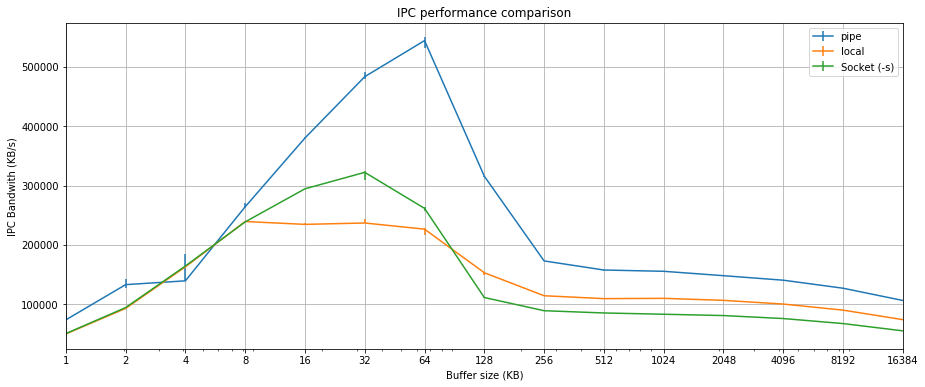

In [59]:
TRIALS = 10

ax = plot_bandwith(
    input_data_file="pipe.json",
    label = "pipe",
    y_label="IPC Bandwith (KB/s)",
    x_label="Buffer size (KB)",
    trials=TRIALS,
    title="IPC performance comparison",
)
plot_bandwith(
    input_data_file="local.json",
    label = "local",
    trials=TRIALS,
    axis = ax,
)
plot_bandwith(
    input_data_file="local_s.json",
    label = "Socket (-s)",
    trials=TRIALS,
    save_name = "IPC_comparison.png",
    axis = ax
)

In [22]:
 with open("pipe.json", 'r') as f:
        content = f.read()
        data = json.loads(content)
        print data

{u'buffer_sizes': [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216], u'aggr_dict': {}, u'output': [u'48745753787', u'48880709643', u'49059915069', u'49226526558', u'49350888373', u'49505856083', u'49630276948', u'49809989829', u'49976806052', u'50143725380', u'50248995568', u'50378291149', u'50497426895', u'50613113086', u'50735546620', u'50859888837', u'50981846354', u'51112582754', u'51235032269', u'51362245190', u'51468681521', u'51562628803', u'51661043526', u'51764459981', u'51867629718', u'51965071042', u'52065683587', u'52162935370', u'52261761847', u'52364939152', u'52470785750', u'52582753428', u'52689250478', u'52796190536', u'52901343792', u'53007982310', u'53114952525', u'53223621933', u'53331047381', u'53437233302', u'53534245427', u'53636029009', u'53732979258', u'53830867885', u'53932788086', u'54030032500', u'54126760308', u'54223328293', u'54320142213', u'54417262258', u'54510628503', u'54608086040', u'5

In [6]:
!ls

.ipynb_checkpoints      lab1_test_0702.data     lab2_local_1202.data    lab2_test_1202.data
ipc                     lab2.ipynb              lab2_socket_s_1202.data


In [40]:
# IO performance varying the buffer size
syscall_distribution = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}


syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}



syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    /* trace(timestamp - cstart);
   printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::read:return 
/execname == "ipc-static" && in_benchmark > 0/
{
    @read = quantize(arg0);
    @tot_r = sum(arg0);
}

syscall::write:return 
/execname == "ipc-static"  && in_benchmark > 0/
{
    @write = quantize(arg0);
    @tot_w = sum(arg0);
}

syscall::exit:entry
/execname == "ipc-static" && in_benchmark <= 0/
{
    printf("pid: %d", pid);
    printf("Read aggregation:");
    printa(@read);
    printf("write aggregation:"); 
    printa(@write);
    
    printf("total read, write:");
    printa(@tot_r); printa(@tot_w);
    
    clear(@tot_r); clear(@tot_w);
    clear(@read); clear(@write);
    printf("##################################"); 
    in_benchmark = 0;

}

END
{
    exit(0);
}
"""
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
print "\n".join(benchmark(
    flags="-i pipe -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)['output'])


kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 13)
('buffer size:', 4096, 'collected so far: ', 26)
('buffer size:', 8192, 'collected so far: ', 39)
('buffer size:', 16384, 'collected so far: ', 52)
('buffer size:', 32768, 'collected so far: ', 65)
('buffer size:', 65536, 'collected so far: ', 78)
('buffer size:', 131072, 'collected so far: ', 91)
('buffer size:', 262144, 'collected so far: ', 104)
('buffer size:', 524288, 'collected so far: ', 117)
('buffer size:', 1048576, 'collected so far: ', 130)
('buffer size:', 2097152, 'collected so far: ', 143)
('buffer size:', 4194304, 'collected so far: ', 156)
('buffer size:', 8388608, 'collected so far: ', 169)
('buffer size:', 16777216, 'collected so far: ', 182)
('values collected:', 195)
pid: 964
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
           

In [4]:
out, dic = benchmark(
    flags="-i local -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 42)
('buffer size:', 2097152, 'collected so far: ', 70)
('buffer size:', 4194304, 'collected so far: ', 70)
('buffer size:', 8388608, 'collected so far: ', 70)
('buffer size:', 16777216, 'collected so far: ', 91)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [35]:
out, dic = benchmark(
    flags="-i local -s -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 63)
('buffer size:', 2097152, 'collected so far: ', 63)
('buffer size:', 4194304, 'collected so far: ', 63)
('buffer size:', 8388608, 'collected so far: ', 84)
('buffer size:', 16777216, 'collected so far: ', 84)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [34]:
out, dic = benchmark(
    flags="-i local -s -q",
    trials=1,
    buff_sizes=[BUFFER_SIZES[-1]],
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 16777216, 'collected so far: ', 0)
('values collected:', 7)
Read aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

write aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

##################################


## Buffer sizes
It seems that all the reads matches the buffer size of the write, and all the buffers are always power of 2

In [38]:
# Scheduler activation
scheduler_script = """

BEGIN {
    in_benchmark = 0
}

syscall::clock_gettime:return
/execname == "ipc-static" && !in_benchmark/
{
    in_benchmark = 1;
    self->cstart = vtimestamp;
   /* printf("tid: %d, pid: %d, return clock_gettime", tid, pid);*/

}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark/
{
    in_benchmark = 0;
  /*  printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::read: 
/execname == "ipc-static" && in_benchmark/
{
}

syscall::write: 
/execname == "ipc-static"  && in_benchmark/
{
}

sched:::off-cpu
/execname == "ipc-static" && in_benchmark/
{
   /* printf("off-cpu tid: %d, pid: %d", tid, pid);*/
    self->off_cpu = vtimestamp;

}
sched:::on-cpu
/execname == "ipc-static" && in_benchmark/
{
    off_time = vtimestamp - self->off_cpu;
   /* printf("on-cpu tid: %d, pid: %d, delay: %d", tid, pid, off_time);*/
    @off_cpu_aggr = sum(off_time);
    @off_cpu_aggr_cnt = count();
}


sched:::sleep
/execname == "ipc-static" && in_benchmark/
{
    self->sleep_start = vtimestamp;
}

sched:::wakeup
/execname == "ipc-static" && in_benchmark && self->sleep_start/
{

    @sleep = sum(vtimestamp - self->sleep_start);
}

syscall::exit:entry
/execname == "ipc-static"/
{
   /* printa("Off_cpu time: %d",@off_cpu_aggr);
    printa("offcpu count: %d",@off_cpu_aggr_cnt);
    printa("sleeptime: %d ms ", @sleep);*/
    printa(@off_cpu_aggr);
    printa(@off_cpu_aggr_cnt);
    printa(@sleep);
}

"""



In [39]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
for sz in BUFFER_SIZES:
    out, dic = benchmark(
        flags="-i pipe -q",
        trials=1,
        buff_sizes=[sz],
        dtrace_script=scheduler_script
    )
    print '\n'.join(out)
    print '###################################'

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('values collected:', 6)
75278726

13517

30554985930

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 2048, 'collected so far: ', 0)
('values collected:', 6)
265831399

8051

45904281809

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 4096, 'collected so far: ', 0)
('values collected:', 6)
403682079

5131

442297336

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 8192, 'collected so far: ', 0)
('values collected:', 6)
516393292

4157

4550308876

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 16384, 'collected so far: ', 0)
('values collected:', 6)
630287816

2060

10403138566

###################################
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 32768, 'collected so far: ', 0)
('valu

## Lab 3

In [3]:
!ipc/ipc-static -i local -b 512 -P mem 1thread
!ipc/ipc-static -i local -b 512 -P l1d 1thread
!ipc/ipc-static -i local -b 512 -P l2 1thread
!ipc/ipc-static -i local -b 512 -P axi 1thread


  pmctype: mem
  INSTR_EXECUTED: 134558787
  CLOCK_CYCLES: 273553262
  CLOCK_CYCLES/INSTR_EXECUTED: 2.032965
  MEM_READ: 29643527
  MEM_READ/INSTR_EXECUTED: 0.220302
  MEM_READ/CLOCK_CYCLES: 0.108365
  MEM_WRITE: 16996227
  MEM_WRITE/INSTR_EXECUTED: 0.126311
  MEM_WRITE/CLOCK_CYCLES: 0.062131

49534.64 KBytes/sec

  pmctype: l1d
  INSTR_EXECUTED: 134540191
  CLOCK_CYCLES: 273991461
  CLOCK_CYCLES/INSTR_EXECUTED: 2.036503
  L1_DCACHE_ACCESS: 58380700
  L1_DCACHE_ACCESS/INSTR_EXECUTED: 0.433928
  L1_DCACHE_ACCESS/CLOCK_CYCLES: 0.213075
  L1_DCACHE_REFILL: 201075
  L1_DCACHE_REFILL/INSTR_EXECUTED: 0.001495
  L1_DCACHE_REFILL/CLOCK_CYCLES: 0.000734

48746.51 KBytes/sec

  pmctype: l2
  INSTR_EXECUTED: 134543520
  CLOCK_CYCLES: 274615925
  CLOCK_CYCLES/INSTR_EXECUTED: 2.041094
  L2_ACCESS: 3992032
  L2_ACCESS/INSTR_EXECUTED: 0.029671
  L2_ACCESS/CLOCK_CYCLES: 0.014537

50604.78 KBytes/sec

  pmctype: axi
  INSTR_EXECUTED: 134536564
  CLOCK_CYCLES: 273917770
  CLOCK_CYCLES/INSTR_EXECUTED: 2

In [59]:
!ipc/ipc-static -i local -b 512 -P axil2 1thread


  pmctype: l2
  INSTR_EXECUTED: 134533642
  CLOCK_CYCLES: 274899092
  CLOCK_CYCLES/INSTR_EXECUTED: 2.043348
  L2_ACCESS: 4201894
  L2_ACCESS/INSTR_EXECUTED: 0.031233
  L2_ACCESS/CLOCK_CYCLES: 0.015285

50905.62 KBytes/sec


In [51]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]

res = benchmark(
    flags="-i local -s -P mem",
    trials=1,
    output_name="pmc_mem.json",
    buff_sizes=BUFFER_SIZES,
    dtrace_script="BEGIN { printf(\"t\");}"
)


kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 1)
('output:', ['', '  pmctype: mem', '  INSTR_EXECUTED: 168301941', '  CLOCK_CYCLES: 423904994', '  CLOCK_CYCLES/INSTR_EXECUTED: 2.518717', '  MEM_READ: 40182543', '  MEM_READ/INSTR_EXECUTED: 0.238753', '  MEM_READ/CLOCK_CYCLES: 0.094791', '  MEM_WRITE: 19505044', '  MEM_WRITE/INSTR_EXECUTED: 0.115893', '  MEM_WRITE/CLOCK_CYCLES: 0.046013', '', '29642.42 KBytes/sec'])
('buffer size:', 2048, 'collected so far: ', 1)
('output:', ['', '  pmctype: mem', '  INSTR_EXECUTED: 91913060', '  CLOCK_CYCLES: 222241343', '  CLOCK_CYCLES/INSTR_EXECUTED: 2.417952', '  MEM_READ: 22681519', '  MEM_READ/INSTR_EXECUTED: 0.246771', '  MEM_READ/CLOCK_CYCLES: 0.102058', '  MEM_WRITE: 12380055', '  MEM_WRITE/INSTR_EXECUTED: 0.134693', '  MEM_WRITE/CLOCK_CYCLES: 0.055705', '', '53832.64 KBytes/sec'])
('buffer size:', 4096, 'collected so far: ', 1)
('output:', ['', '  pmctype: mem', '  INSTR_EXECUTED: 54619757', '  CLOCK_CYC

In [ ]:
benchmark(
    flags="-i local -s -P l1d",
    trials=1,
    output_name="pmc_l1d.json",
    buff_sizes=BUFFER_SIZES,
    dtrace_script="BEGIN { printf(\"t\");}"
)

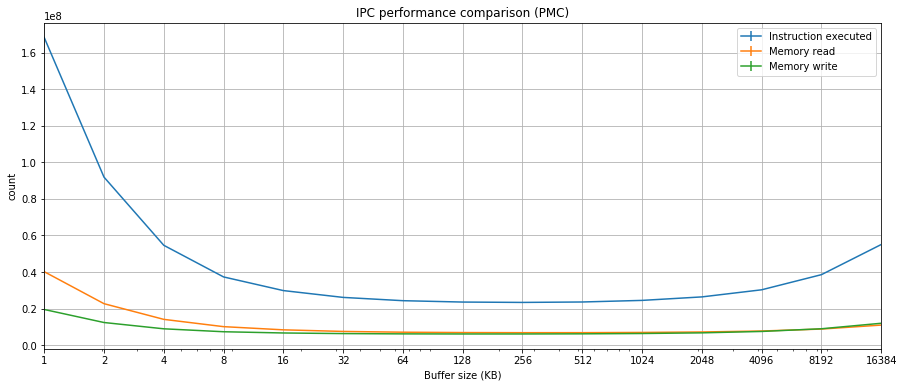

In [58]:
ax = plot_pmc(
    input_data_file="pmc_test.json",
    pmc_to_plot="INSTR_EXECUTED",
    label = "Instruction executed",
    y_label="count",
    x_label="Buffer size (KB)",
    trials=1,
    title="IPC performance comparison (PMC)",
)

plot_pmc(
    input_data_file="pmc_test.json",
    pmc_to_plot="MEM_READ",
    label = "Memory read",
    trials=1,
    axis = ax,
)
plot_pmc(
    input_data_file="pmc_test.json",
    pmc_to_plot="MEM_WRITE",
    label = "Memory write",
    trials=1,
    axis = ax,
)